## 0. Introduction

The aim of this lab is to get familiar with **Neural Networks**. We will be using some code extracts that were implemented on the week 4 Classification I lab and build a Neural Network.

1.   This lab is the third course-work activity **Assignment 1 Part 3: Neural Networks**
2. Assignment 1 is split into 3 parts: Part 1 - Regression (Lab 3), and Part 2 - Classification (Lab 4) and Part 3 - Neural Networks (Lab 6). The three parts need to be submitted together by  **Monday, 11th November 2024, 10:00am**
3. All questions need to be completed and are assessed.
4. For each lab, a report answering the <font color = 'red'>**questions in red**</font> should be included along with the completed Notebook (.ipynb)
5. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.).
6. Make sure that **any figures or code** you comment on, are **included in the report**.
7. There are three parts of Assignment 1, therefore you should submit a zip file that contains 1 x Notebook and 1 x PDF for each part. In total: 3 x Notebooks and 3 x PDFs in the submission zip. Make sure the file is well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
8. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
9. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab, we will be using the [iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset).

## 0.1 Intro to Neural Networks

As covered in the lecture notes, Neural Networks (NN) are inspired by biological brains. Each "neuron" does a very simple calculation, however collectively they can do powerful computations.

A simple model neuron is called a Perceptron and is comprised of three components:
1. The weights
2. The input function
3. The activation function

perceptron.png

We can re-imagine the logistic regression unit as a neuron (function) that multiplies the input by the parameters (weights) and squashes the resulting sum through the sigmoid.

A Feed Forward NN will be a connected set of logistic regression units, arranged in layers. Each unit’s output is a non-linear function (e.g., sigmoid, step function) of a linear combination of its inputs.
nn.svg

We will use the sigmoid as an activation function. Add the sigmoid function and `LogisticRegression` class from week 4 lab below.
Change the parameter initialization in `LogisticRegression`, so that a random set of initial weights is used.



<u><font color="red">**Q1.** Why is it important to use a random set of initial weights rather than initializing all weights as zero in a Neural Network? [2 marks] </font></u>


In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)

In [ ]:
## sigmoid
def sigmoid(s):
    return 1 / (1 + torch.exp(-s))

In [ ]:
## logistic regression class
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1, num_features) * 0.01, requires_grad=True)  # Small random initialization
    #print(f"LogisticRegression weight initialized with shape: {self.weight.shape}")


  def forward(self, x):
    y = 0
    ### your code here

    #print(f"Input x shape: {x.shape}")
    #print(f"Weight shape: {self.weight.shape}")

    linear_output = torch.matmul(x, self.weight.T)  # Linear component θᵀx
    y = sigmoid(linear_output)  # Sigmoid to get probabilities
    return y

# 1. The XOR problem

Let's revisit the XOR problem.

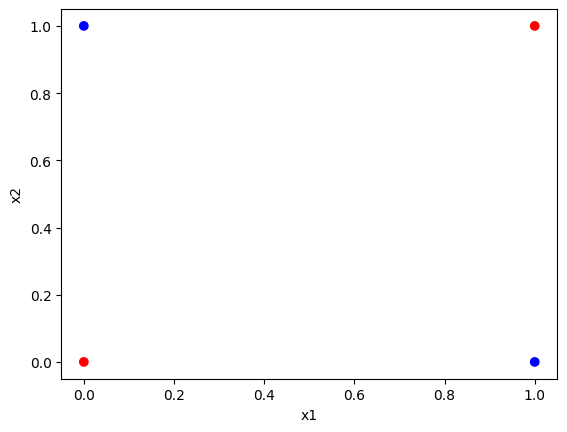

In [ ]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<u><font color="red"> **Q2.** How does a NN solve the XOR problem? [1 marks]</font></u>


We will implement back-propagation on a Feed Forward network to solve the XOR problem. The nework will have 2 inputs, 2 hidden neurons and one output neuron. The architecture is visualised as follows:

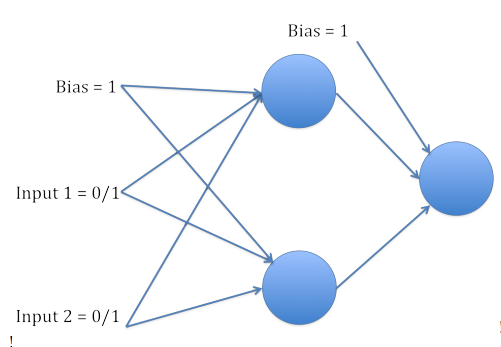

Using `LogisticRegression` and `sigmoid` from week 4 lab, implement the forward pass in the class below. Assume a single sample at a time (i.e. the shape of `x` is `(1, num_features`)). [2 marks]

Hint: Check `ModuleList` [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html).

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_inputs, num_neurons, num_outputs):
    super().__init__()
    self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for i in range(num_neurons)])
    self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1) for i in range(num_outputs)]) # +1 for the bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    y_hidden = torch.ones(len(self.hidden_layer) + 1)
    for i, neuron in enumerate(self.hidden_layer):
        # Pass x directly to each neuron without concatenating the bias term
        y_hidden[i] = neuron(x)


    y_hidden_with_bias = y_hidden.view(1, -1)  # Shape: (1, num_neurons + 1)
    y_output = torch.zeros(len(self.output_layer))
    for i, neuron in enumerate(self.output_layer):
        y_output[i] = neuron(y_hidden_with_bias)

    return y_output





  def backward_pass(self, x: torch.tensor, target: torch.tensor, lr: float) -> None:
        # Flatten input tensor for single sample
        x = x.flatten()

        y_hidden = torch.ones(len(self.hidden_layer) + 1)  # +1 for bias
        for i, neuron in enumerate(self.hidden_layer):
            y_hidden[i] = neuron(x)
        y_hidden_with_bias = y_hidden.view(1, -1)  # Shape: (1, num_neurons + 1)

        output = torch.zeros(len(self.output_layer))
        for i, neuron in enumerate(self.output_layer):
            output[i] = neuron(y_hidden_with_bias)

        output_deltas = torch.zeros(len(self.output_layer))
        for k in range(len(self.output_layer)):
            y_k = output[k]
            t_k = target.item()
            g_prime_x_k = y_k * (1 - y_k)
            output_deltas[k] = (y_k - t_k) * g_prime_x_k

        hidden_deltas = torch.zeros(len(self.hidden_layer))
        for j in range(len(self.hidden_layer)):
            g_prime_x_j = y_hidden[j] * (1 - y_hidden[j])
            weighted_sum = sum(self.output_layer[k].weight[0, j] * output_deltas[k] for k in range(len(self.output_layer)))
            hidden_deltas[j] = g_prime_x_j * weighted_sum

        for k, neuron in enumerate(self.output_layer):
            for j in range(len(y_hidden)):
                neuron.weight.data[0, j] -= lr * output_deltas[k] * y_hidden[j]


        for j, neuron in enumerate(self.hidden_layer):
            for i in range(len(x)):
                neuron.weight.data[0, i] -= lr * hidden_deltas[j] * x[i]



In [ ]:
# test it works!!
x_test = torch.tensor([0., 0., 1.]) # last value is the bias
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
print(model(x_test))
print(model)
for name, param in model.named_parameters():
  print(name, param)

print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

tensor([0.4986], grad_fn=<CopySlices>)
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0-1): 2 x LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
hidden_layer.0.weight Parameter containing:
tensor([[-0.0089, -0.0151,  0.0037]], requires_grad=True)
hidden_layer.1.weight Parameter containing:
tensor([[0.0146, 0.0094, 0.0077]], requires_grad=True)
output_layer.0.weight Parameter containing:
tensor([[ 0.0019,  0.0126, -0.0129]], requires_grad=True)

Hidden layer weight matrix:
tensor([[[-0.0089, -0.0151,  0.0037]],

        [[ 0.0146,  0.0094,  0.0077]]], grad_fn=<StackBackward0>)


In the `NeuralNetwork` class above, fill in the `backward_pass()` method.

The implementation should support outputs of any size. To implement the backward pass, follow the steps below:



*   **Step 1:** For each output, $k$, calculate the partial derivative: $\delta_{k} = (y_{k}-t_{k}) \times g'(x_{k})$ \\
where $y_{k}$ is the response of the output neuron and $t_{k}$ is the desired output (target). The derivative of the sigmoid function $g'(x_{k})$ is defined as $g'(x_{k}) = g(x_{k}) × (1 - g(x_{k}))$ [1 marks]
*  **Step 2:** We now need to propagate this error to the hidden neurons. To accomplish this remember that: $$
 \delta_{j} = g^\prime(x_{j}) \sum_{k} w_{jk} \delta_{k}
$$  where $\delta_{j}$ is the error on the j-th hidden neuron,$x_{j}$ is the value of the hidden neuron (before it has been passed through the sigmoid function), $g^\prime$ is the derivative of the sigmoid function, $\delta_{k}$ is the error from the output neuron calculated in step 1, and $w_{jk}$ is the weight from the hidden neuron $j$ to the output neuron $k$. [1 marks]

* **Step 3:** We now need to update the output weights, i.e. the connections from the hidden neurons to the output neurons. This is accomplished using the formula: $$
 w_{jk} = w_{jk} - \eta \delta_{k} \alpha_{j}
$$ where $w_{jk}$ is the weight connecting the j-th hidden neuron to the k-th output neuron. $\alpha_{j}$ is the activity of the j-th hidden neuron (after it has been transformed by the sigmoid function), $\delta_{k}$ is the error from the output neuron stored in output\_deltas and $\eta$ is the learning rate [1 mark]

* **Step 4:**  Finally we need to update the hidden weights, i.e. the connections from the hidden neurons to the inputs. Here, again we use this equation $$
 w_{ij} = w_{ij} - \eta \delta_{j} x_{i}
$$ where $w_{ij}$ is the weight connecting the i-th input to the j-th hidden neuron. $x_{i}$ is the i-th input, $\delta_{j}$ is the backpropagated error (i.e., hidden deltas) from the j-th hidden neuron and $\eta$ is the learning rate. [1 mark]



In [ ]:
# Ensure x_test is reshaped correctly before passing to the model
#x_test = x_test.view(1, -1)  # Reshape to (1, num_features) if it's a single feature vector

# Now run the forward and backward passes with reshaped x_test
#output = model.forward(x_test)
#model.backward_pass(x_test, y_test, 1)


In [ ]:
# test it works
model.backward_pass(x_test, y_test, 1)

Now modify the code below to train a model on the XOR problem. Make sure to use an appropriate lr and number of iterations. Use the BCE method from week 4 to visualize cost. [1 mark]

In [ ]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    y_pred = torch.clamp(y_pred, min=1e-7, max=1 - 1e-7)
    loss = -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss


torch.Size([4, 3])


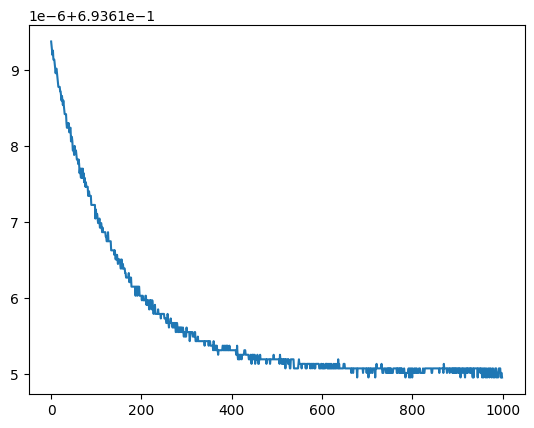

tensor([0., 1., 1., 0.]) tensor([0.5000, 0.5000, 0.5000, 0.0000], grad_fn=<CopySlices>)


In [ ]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
print(x.shape)
y = torch.tensor([0., 1., 1., 0.])
lr = 0.01
iterations = 1000
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)

errors = list()
for ep in range(iterations):
  error = 0
  for i in range(x.shape[0]):
    y_pred = model(x[i])
    error += bce(y[i], y_pred)
    model.backward_pass(x[i], y[i], lr)
  errors.append(error/x.shape[0])
plt.plot(list(range(iterations)), [e.detach().numpy() for e in errors])
plt.show()

y_pred = torch.zeros_like(y)
for i in range(x.shape[1]):
  y_pred[i] = model(x[i])
print(y, y_pred)



# 2. Iris Dataset
We will now use pytorch built-in methods to create an MLP classifier for the iris dataset.

In [ ]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [ ]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    n_set = (x - mu) / sigma
    return n_set

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data,
    iris.target,
    test_size=0.2,
    random_state=42
)

x_train = torch.from_numpy(X_train).float()
x_test = torch.from_numpy(X_test).float()


y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()


mu = x_train.mean(dim=0)
sigma = x_train.std(dim=0)
x_train_normalized = norm_set(x_train, mu, sigma)
x_test_normalized = norm_set(x_test, mu, sigma)

x_train = x_train_normalized
x_test = x_test_normalized


print("X_train_normalized shape:", x_train.shape)
print("X_test_normalized shape:", x_test.shape)
print("Mean of normalized X_train:", x_train.mean(dim=0))
print("Std of normalized X_train:", x_train.std(dim=0))


X_train_normalized shape: torch.Size([120, 4])
X_test_normalized shape: torch.Size([30, 4])
Mean of normalized X_train: tensor([ 2.5233e-07, -6.7155e-07,  1.1126e-07,  1.9968e-07])
Std of normalized X_train: tensor([1.0000, 1.0000, 1.0000, 1.0000])


Using pytorch built in methods (and using the training loop from week 4 as guideline for the train loop), build an MLP with one hidden layer. Train the network multiple times for the following number of hidden neurons `{1, 2, 4, 8, 16, 32}`.

<u><font color="red"> **Q3.** Explain the performance of the different networks on the training and test sets. How does it compare to the logistic regression example? Make sure that the data you are refering to is clearly presented and appropriately labeled in the report. [8 marks]</font></u>


Training MLP with 1 hidden neurons


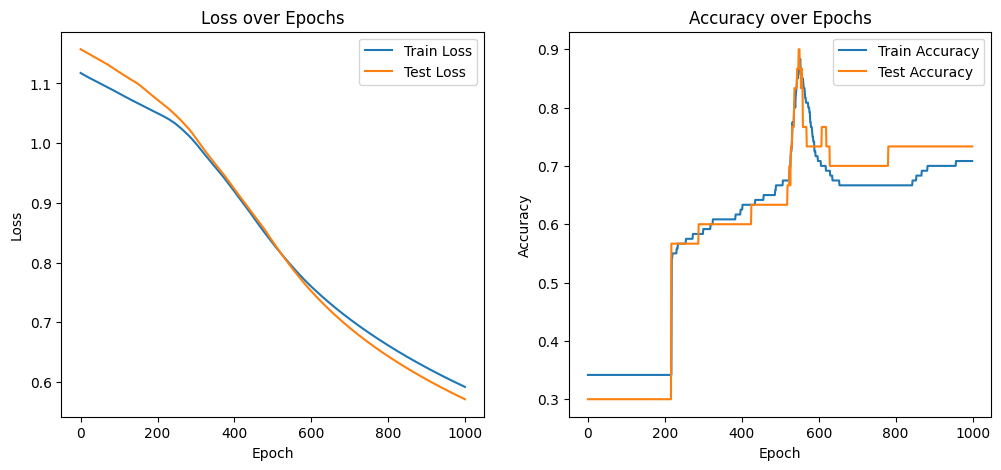


Training MLP with 2 hidden neurons


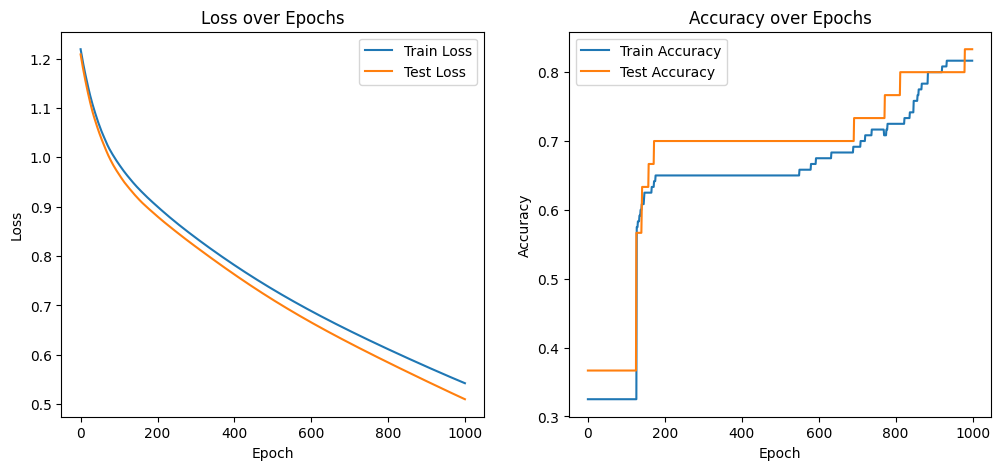


Training MLP with 4 hidden neurons


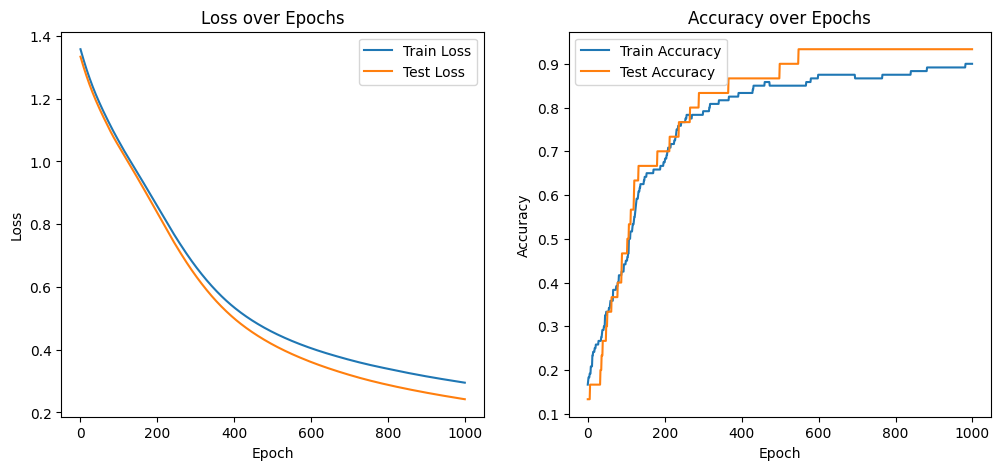


Training MLP with 8 hidden neurons


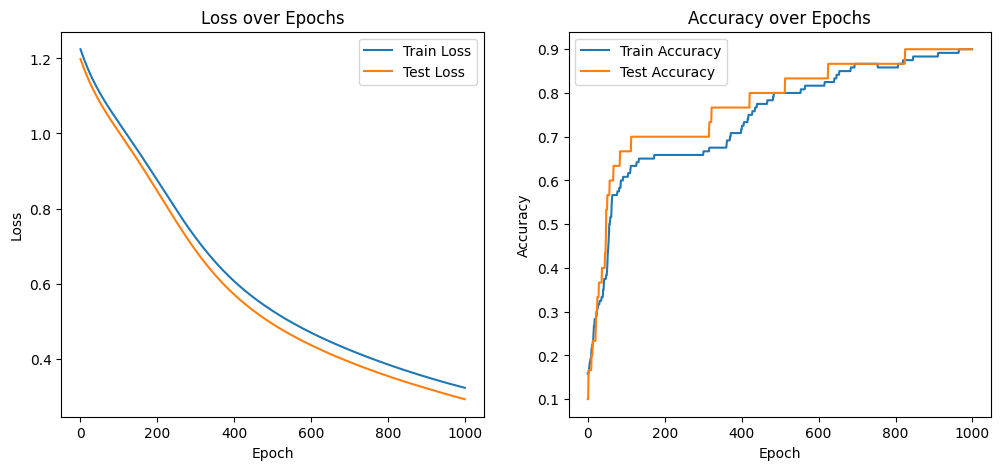


Training MLP with 16 hidden neurons


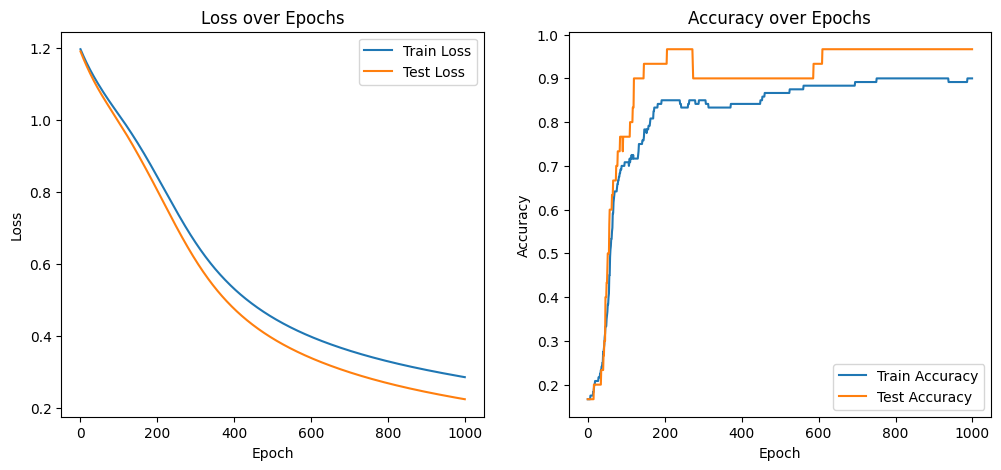


Training MLP with 32 hidden neurons


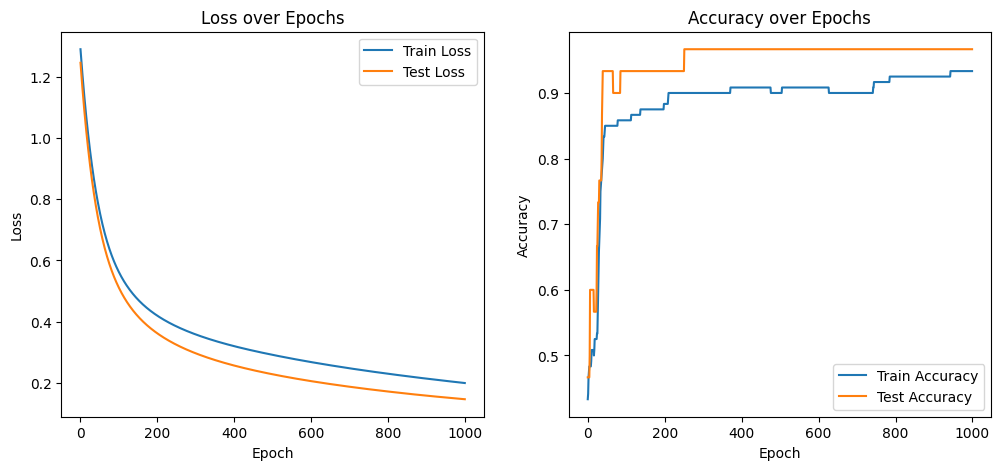

In [ ]:



class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)
        return x


def train_model(model, x_train, y_train, x_test, y_test, learning_rate=0.01, epochs=1000):
    criterion = nn.CrossEntropyLoss()  # loss function for multi-class
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []

    for epoch in range(epochs):

        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()


        train_loss_list.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        train_accuracy = (predicted == y_train).float().mean().item()
        train_accuracy_list.append(train_accuracy)


        model.eval()
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)
            test_loss_list.append(test_loss.item())
            _, test_predicted = torch.max(test_outputs, 1)
            test_accuracy = (test_predicted == y_test).float().mean().item()
            test_accuracy_list.append(test_accuracy)


        #if epoch % 100 == 0:
            #print(f"Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label="Train Loss")
    plt.plot(test_loss_list, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")


    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_list, label="Train Accuracy")
    plt.plot(test_accuracy_list, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over Epochs")
    plt.show()

    return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list

hidden_neurons = [1, 2, 4, 8, 16, 32]
outs = {}

for hidden_size in hidden_neurons:
    print(f"\nTraining MLP with {hidden_size} hidden neurons")
    model = MLP(input_size=4, hidden_size=hidden_size, output_size=3)  # 3 output classes for Iris dataset
    outs[hidden_size] = train_model(model, x_train, y_train, x_test, y_test, learning_rate=0.01, epochs=1000)


In [ ]:

summary_results = []
for hidden_size, (train_loss_list, test_loss_list, train_acc_list, test_acc_list) in outs.items():
    final_train_acc = train_acc_list[-1]
    final_test_acc = test_acc_list[-1]
    summary_results.append((hidden_size, final_train_acc, final_test_acc))

print("Summary of Model Performance:")
print("Hidden Neurons | Final Train Accuracy | Final Test Accuracy")
for result in summary_results:
    print(f"{result[0]:<15} | {result[1]:<18.4f} | {result[2]:<16.4f}")


Summary of Model Performance:
Hidden Neurons | Final Train Accuracy | Final Test Accuracy
1               | 0.7083             | 0.7333          
2               | 0.8167             | 0.8333          
4               | 0.9000             | 0.9333          
8               | 0.9000             | 0.9000          
16              | 0.9000             | 0.9667          
32              | 0.9333             | 0.9667          
